In [42]:
import pandas as pd
import numpy as np

In [43]:
# Load data from new_sample/butter_manual_raw.csv
df = pd.read_csv('../data/plant_butter/raw.csv')
df.head()

,R,G,B,y
0,254,155,61,1
1,255,165,76,1
2,251,160,90,1
3,254,173,120,1
4,235,168,151,1


In [44]:
# Display mean colors by y
mean_colors = df.groupby('y').mean()

# Print in hex
for i in range(0, mean_colors.shape[0]):
    # print(f'#{int(mean_colors.iloc[i, 0]):02x}{int(mean_colors.iloc[i, 1]):02x}{int(mean_colors.iloc[i, 2]):02x}')
    # Print in RGB
    print(f'({int(mean_colors.iloc[i, 0])}, {int(mean_colors.iloc[i, 1])}, {int(mean_colors.iloc[i, 2])})')

#63c5ec
#f2a979


In [45]:
# Center data
def normalize(df):
    print(f'Centering data with mean: \n{df.mean()}')
    mean = df.mean()
    df = df - df.mean()
    print(f'Normalizing data with std: \n{df.std()}')
    std = df.std()
    df = df / df.std()
    return df, mean, std

df_x, df_y = df.iloc[:, 0:3], df.iloc[:, 3]
df_x_norm, df_mean, df_std = normalize(df_x)

Centering data with mean: 
R    176.538462
G    182.384615
B    174.307692
dtype: float64
Normalizing data with std: 
R    86.184507
G    18.954061
B    68.822700
dtype: float64


In [46]:
# Train PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_x_pca = pca.fit_transform(df_x_norm)

# Write df_x_pca to csv
pd.DataFrame(df_x_pca, columns=['PCA1', 'PCA2']).to_csv('../data/new_samples/butter_manual_pca.csv', index=False)

In [47]:
# Pca coefs
pca.components_

array([[ 0.55226792, -0.5682887 , -0.60995745],
       [-0.75665753, -0.64882536, -0.08059178]])

In [48]:
# Plot PCA
import matplotlib.pyplot as plt
def pca_plot(df_x_pca, df_y, figsize=(5,5), colorbar=True, title=None, annotate=False):

    plt.figure(figsize=(7,5))
    plt.scatter(df_x_pca[:, 0], df_x_pca[:, 1], c=df_y, cmap='viridis')

    # Grid and lines
    plt.axhline(0, color='grey')
    plt.axvline(0, color='grey')
    plt.grid()
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # Colorbar
    if colorbar:
        plt.colorbar()

    # Title
    if title:
        plt.title(f'PCA: {title}')

    # Write y for each point
    if annotate:
        for i, txt in enumerate(df_y):
            plt.annotate(txt, (df_x_pca[i, 0]+0.05, df_x_pca[i, 1]+0.05))

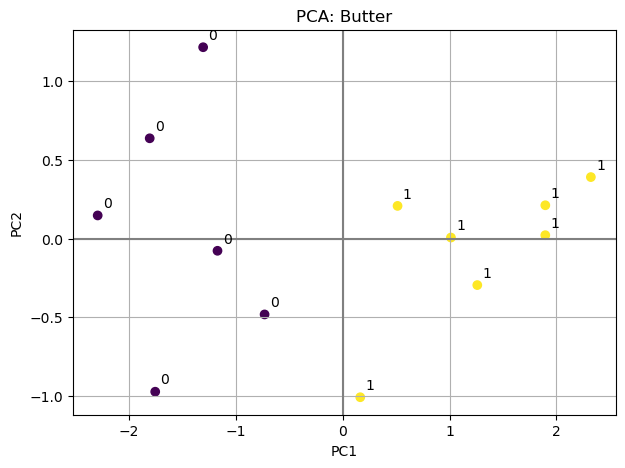

In [49]:
pca_plot(df_x_pca, df_y, colorbar=False, title='Butter', annotate=True)

# Add 

plt.show()

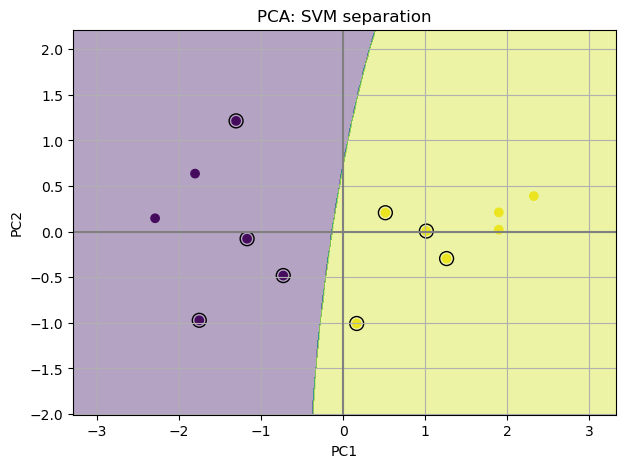

In [50]:
# Train SVM
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(df_x_pca, df_y)

# Plot SVM
def svm_plot(df_x_pca, df_y, svm, figsize=(5,5), colorbar=False, title=None, annotate=False):

        # Create meshgrid
        x_min, x_max = df_x_pca[:, 0].min() - 1, df_x_pca[:, 0].max() + 1
        y_min, y_max = df_x_pca[:, 1].min() - 1, df_x_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))

        # Plot decision boundary
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # Plot PCA
        pca_plot(df_x_pca, df_y, figsize=figsize, colorbar=colorbar, title=title, annotate=annotate)
        plt.contourf(xx, yy, Z, alpha=0.4)


svm_plot(df_x_pca, df_y, svm, title='SVM separation')
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')
plt.show()

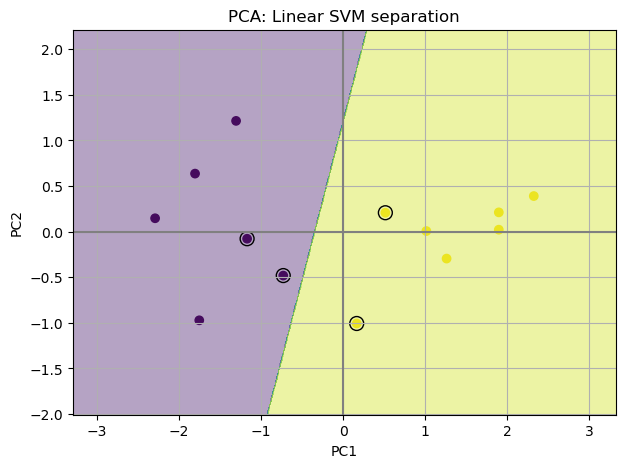

In [51]:
# Linear SVM
svm = SVC(kernel='linear', C=1)
svm.fit(df_x_pca, df_y)
svm_plot(df_x_pca, df_y, svm, title='Linear SVM separation')
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')

# Get hyperplane equation
w = svm.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-2, 2)
yy = a * xx - (svm.intercept_[0]) / w[1]

In [52]:
# Get coefs
b = svm.intercept_[0]
w0 = svm.coef_[0][0]
w1 = svm.coef_[0][1]

# Print equation
print(f'y = {w0:.2f}x1 + {w1:.2f}x2 + {b:.2f}')

y = 1.25x1 + -0.36x2 + 0.43


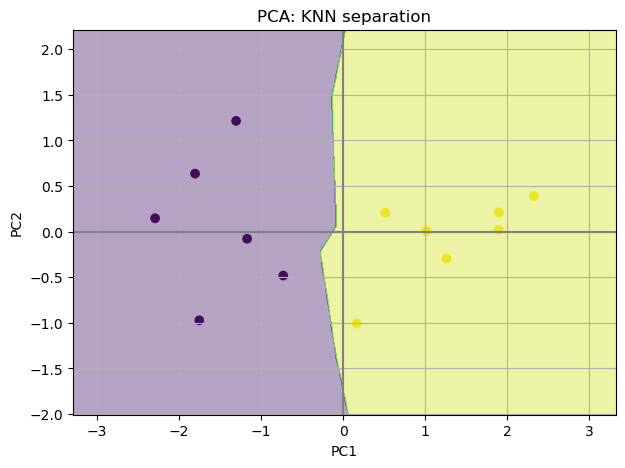

In [53]:
# Train KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(df_x_pca, df_y)

# Plot KNN
def knn_plot(df_x_pca, df_y, knn, figsize=(5,5), colorbar=False, title=None, annotate=False):

        # Create meshgrid
        x_min, x_max = df_x_pca[:, 0].min() - 1, df_x_pca[:, 0].max() + 1
        y_min, y_max = df_x_pca[:, 1].min() - 1, df_x_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                np.arange(y_min, y_max, 0.01))

        # Plot decision boundary
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # Plot PCA
        pca_plot(df_x_pca, df_y, figsize=figsize, colorbar=colorbar, title=title, annotate=annotate)
        plt.contourf(xx, yy, Z, alpha=0.4)

knn_plot(df_x_pca, df_y, knn, title='KNN separation')
plt.show()

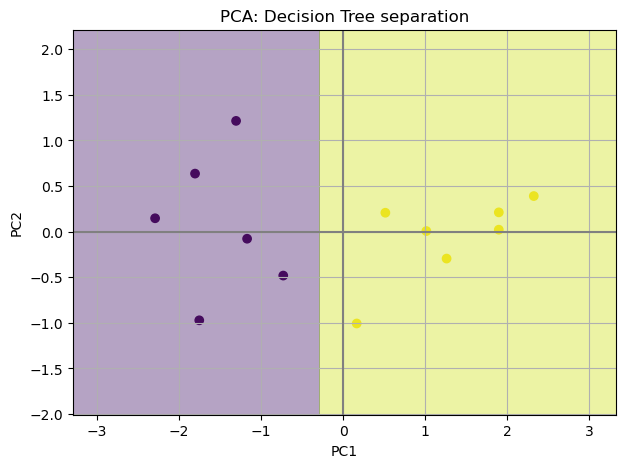

In [54]:
# Train Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(df_x_pca, df_y)

# Plot Decision Tree
def dt_plot(df_x_pca, df_y, dt, figsize=(5,5), colorbar=False, title=None, annotate=False):
    
            # Create meshgrid
            x_min, x_max = df_x_pca[:, 0].min() - 1, df_x_pca[:, 0].max() + 1
            y_min, y_max = df_x_pca[:, 1].min() - 1, df_x_pca[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                    np.arange(y_min, y_max, 0.01))
    
            # Plot decision boundary
            Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            # Plot PCA
            pca_plot(df_x_pca, df_y, figsize=figsize, colorbar=colorbar, title=title, annotate=annotate)
            plt.contourf(xx, yy, Z, alpha=0.4)

dt_plot(df_x_pca, df_y, dt, title='Decision Tree separation')

Cluster means:
Cluster 0: -1.51, 0.08
Cluster 1: 1.29, -0.07
Cluster 2: nan, nan


/tmp/ipykernel_310865/1452081624.py:4: RuntimeWarning: Mean of empty slice.
  cluster_means.append(df_x_pca[df_y==i].mean(axis=0))
/home/quakumei/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<Figure size 500x500 with 0 Axes>

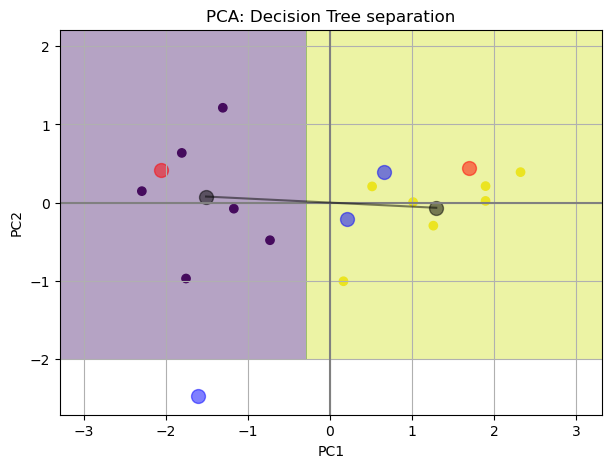

In [69]:
# Calculate cluster means
cluster_means = []
for i in range(3):
    cluster_means.append(df_x_pca[df_y==i].mean(axis=0))

# Plot cluster means
plt.figure(figsize=(5,5))
dt_plot(df_x_pca, df_y, dt, title='Decision Tree separation')
plt.scatter([x[0] for x in cluster_means], [x[1] for x in cluster_means], c='k', s=100, alpha=0.5)

# Print cluster means
print('Cluster means:')
for i, mean in enumerate(cluster_means):
    print(f'Cluster {i}: {mean[0]:.2f}, {mean[1]:.2f}')
    

# Draw a line between cluster means
for i in range(3):
    for j in range(i+1, 3):
        plt.plot([cluster_means[i][0], cluster_means[j][0]], [cluster_means[i][1], cluster_means[j][1]], c='k', alpha=0.5)


active_points = pd.DataFrame([[255,150,150], [50,200,255]], columns=['R', 'G', 'B'])

# Normalize
active_points = (active_points - df_mean) / df_std

active_points_pca = pca.transform(active_points)

# Plot active points
plt.scatter(active_points_pca[:, 0], active_points_pca[:, 1], c='r', s=100, alpha=0.5)


# Plot middle point rgb(209, 180, 183) rgb(253, 233, 240) rgb(196, 166, 169)
middle_point = pd.DataFrame([[209, 180, 183], [253, 233, 240], [196,166,169]], columns=['R', 'G', 'B'])
middle_point = (middle_point - df_mean) / df_std
middle_point_pca = pca.transform(middle_point)
plt.scatter(middle_point_pca[:, 0], middle_point_pca[:, 1], c='b', s=100, alpha=0.5)



plt.show()


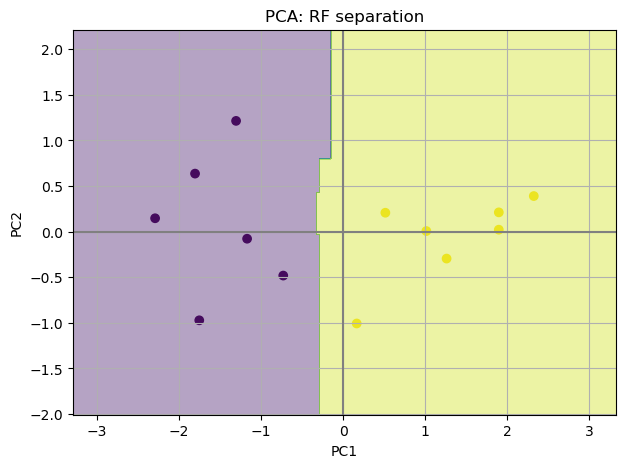

In [56]:
# Train RF
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf.fit(df_x_pca, df_y)

# Plot RF
def rf_plot(df_x_pca, df_y, rf, figsize=(5,5), colorbar=False, title=None, annotate=False):
    # Create meshgrid
    x_min, x_max = df_x_pca[:, 0].min() - 1, df_x_pca[:, 0].max() + 1
    y_min, y_max = df_x_pca[:, 1].min() - 1, df_x_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    # Plot decision boundary
    Z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot PCA
    pca_plot(df_x_pca, df_y, figsize=figsize, colorbar=colorbar, title=title, annotate=annotate)
    plt.contourf(xx, yy, Z, alpha=0.4)

rf_plot(df_x_pca, df_y, rf, title='RF separation')

/tmp/ipykernel_310865/275761163.py:25: RuntimeWarning: Mean of empty slice.
  cluster_means.append(df_x_pca[df_y==i].mean(axis=0))
/home/quakumei/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<Figure size 500x500 with 0 Axes>

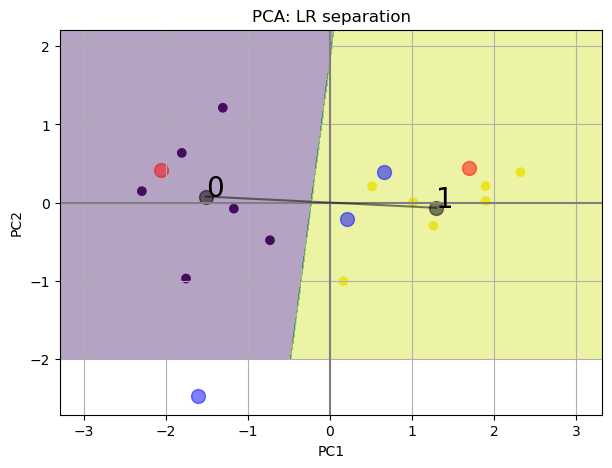

In [64]:
# Logistic Regression - Binary Classification
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(df_x_pca, df_y)

# Plot LR
def lr_plot(df_x_pca, df_y, lr, figsize=(5,5), colorbar=False, title=None, annotate=False):
    # Create meshgrid
    x_min, x_max = df_x_pca[:, 0].min() - 1, df_x_pca[:, 0].max() + 1
    y_min, y_max = df_x_pca[:, 1].min() - 1, df_x_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    # Plot decision boundary
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot PCA
    pca_plot(df_x_pca, df_y, figsize=figsize, colorbar=colorbar, title=title, annotate=annotate)
    plt.contourf(xx, yy, Z, alpha=0.4)


# Calculate cluster means
cluster_means = []
for i in range(3):
    cluster_means.append(df_x_pca[df_y==i].mean(axis=0))

# Plot cluster means
plt.figure(figsize=(5,5))
lr_plot(df_x_pca, df_y, lr, title='LR separation')

plt.scatter([x[0] for x in cluster_means], [x[1] for x in cluster_means], c='k', s=100, alpha=0.5)

# Draw a line between cluster means
for i in range(3):
    for j in range(i+1, 3):
        plt.plot([cluster_means[i][0], cluster_means[j][0]], [cluster_means[i][1], cluster_means[j][1]], c='k', alpha=0.5)


active_points = pd.DataFrame([[255,150,150], [50,200,255]], columns=['R', 'G', 'B'])

# Normalize
active_points = (active_points - df_mean) / df_std

active_points_pca = pca.transform(active_points)

# Plot active points
plt.scatter(active_points_pca[:, 0], active_points_pca[:, 1], c='r', s=100, alpha=0.5)


# Plot middle point rgb(209, 180, 183) rgb(253, 233, 240) rgb(196, 166, 169)


middle_point = pd.DataFrame([[209, 180, 183], [253, 233, 240], [196,166,169]], columns=['R', 'G', 'B'])
middle_point = (middle_point - df_mean) / df_std
middle_point_pca = pca.transform(middle_point)
plt.scatter(middle_point_pca[:, 0], middle_point_pca[:, 1], c='b', s=100, alpha=0.5)

# Also, annotate classes
for i in range(3):
    plt.annotate(i, (cluster_means[i][0], cluster_means[i][1]), fontsize=20)
    


plt.show()




In [65]:
# Logistic Regression formula
print('LR formula: y = {:.2f} + {:.2f}x1 + {:.2f}x2'.format(lr.intercept_[0], lr.coef_[0][0], lr.coef_[0][1]))

# Logistic Regression probability formula
print('LR probability formula: p = 1 / (1 + exp(-({:.2f} + {:.2f}x1 + {:.2f}x2)))'.format(lr.intercept_[0], lr.coef_[0][0], lr.coef_[0][1]))

# Calculate proba for middle points
middle_point_proba = lr.predict_proba(middle_point_pca)
print('Middle point probabilities: {}'.format(middle_point_proba))

# Predict classes for middle points
middle_point_pred = lr.predict(middle_point_pca)
print('Middle point classes: {}'.format(middle_point_pred))

LR formula: y = 0.36 + 1.58x1 + -0.20x2
LR probability formula: p = 1 / (1 + exp(-(0.36 + 1.58x1 + -0.20x2)))
Middle point probabilities: [[0.3270131  0.6729869 ]
 [0.84484772 0.15515228]
 [0.20929882 0.79070118]]
Middle point classes: [1 0 1]
